In [28]:
using Plots, LinearAlgebra, HDF5, Random, FastGaussQuadrature, LaTeXStrings, Statistics

In [29]:
include("../src/splines.jl")
include("../src/poisson_solver_splines.jl")
include("../src/bump_on_tail_distributions.jl")
include("../src/sampling.jl")
include("../src/time_marching.jl")
include("../src/h5routines.jl")
include("../src/visualisation.jl");

In [30]:
fpath = "../runs/BoT_Np5e4_k_010_050_np_10_T25.h5"

μₛₐₘₚ = h5read(fpath, "parameters/mu_samp")
μₜᵣₐᵢₙ = h5read(fpath, "parameters/mu_train")

IP = IntegratorParameters(h5read(fpath, "parameters/dt"),
                          h5read(fpath, "parameters/n_t"), 
                          h5read(fpath, "parameters/n_s"),
                          h5read(fpath, "parameters/n_h"),
                          h5read(fpath, "parameters/N_p")
                          h5read(fpath, "parameters/n_p"),
                            )

S = PBSpline(h5read(fpath, "parameters/p"), IP.nₕ, 2.0*pi/μₛₐₘₚ[1])

X = h5read(fpath, "snapshots/X");
V = h5read(fpath, "snapshots/V");
E = h5read(fpath, "snapshots/E");
# D = h5read(fpath, "snapshots/D");
# Φ = h5read(fpath, "snapshots/Phi");

In [31]:
# Reference draw
P₀ = Particles(X[:,1], V[:,1], ones(IP.Nₚ) .* S.L ./ IP.Nₚ);

In [32]:
μₛₐₘₚ' 

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.3  0.03  0.1  4.5  0.5

In [33]:
μₜᵣₐᵢₙ

10×5 Matrix{Float64}:
 0.1       0.03  0.1  4.5  0.5
 0.144444  0.03  0.1  4.5  0.5
 0.188889  0.03  0.1  4.5  0.5
 0.233333  0.03  0.1  4.5  0.5
 0.277778  0.03  0.1  4.5  0.5
 0.322222  0.03  0.1  4.5  0.5
 0.366667  0.03  0.1  4.5  0.5
 0.411111  0.03  0.1  4.5  0.5
 0.455556  0.03  0.1  4.5  0.5
 0.5       0.03  0.1  4.5  0.5

# EVD

In [34]:
# XV = hcat(X, V);
XV = copy(X)
for p in 1:IP.nₚ
    # XV = hcat(XV, V[:,1+(p-1)*IP.nₛ])
    XV = hcat(XV, V[:,1+(p-1)*IP.nₛ]) #, E[:,p*IP.nₛ])
    #print(1+(p-1)*IP.nₛ, " ", p*IP.nₛ, "\n" )
end

# clear 
X, V = 0, 0
GC.gc()

In [35]:
size(XV)

(5000, 2520)

In [36]:
function sorteigen(evals::Vector{T},evecs::Matrix{T}) where {T<:Real}
    p = sortperm(abs.(evals), lt=isless, rev=true)
    return evals[p], evecs[:, p]
end

sorteigen (generic function with 1 method)

In [37]:
# @time F = eigen(Xₑₓₜ' * Xₑₓₜ);
# Λ, Ω = sorteigen(F.values, F.vectors);
@time F = eigen(XV' * XV);
Λ, Ω = sorteigen(F.values, F.vectors);
@time Fₑ = eigen(E' * E);
Λₑ, Ωₑ = sorteigen(Fₑ.values, Fₑ.vectors);

  3.755001 seconds (20 allocations: 194.703 MiB)
  3.920807 seconds (20 allocations: 193.165 MiB, 0.68% gc time)


In [38]:
# clear
F, Fₑ = 0, 0
GC.gc()

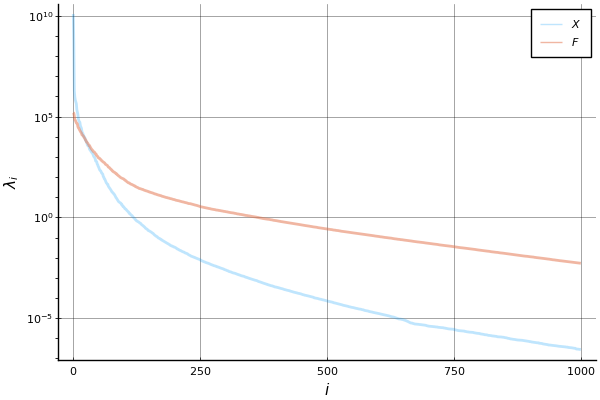

In [39]:
plot(xlabel = L"$i$", ylabel = L"$\lambda_i$", yscale = :log10, 
     grid = true, gridalpha = 0.5)
plot!(abs.(Λ )[1:1000], linewidth = 2, alpha = 0.25, label = L"$X$")
plot!(abs.(Λₑ)[1:1000], linewidth = 2, alpha = 0.5,  label = L"$F$")
#savefig("../Presentations/SVDs_BoT.pdf")

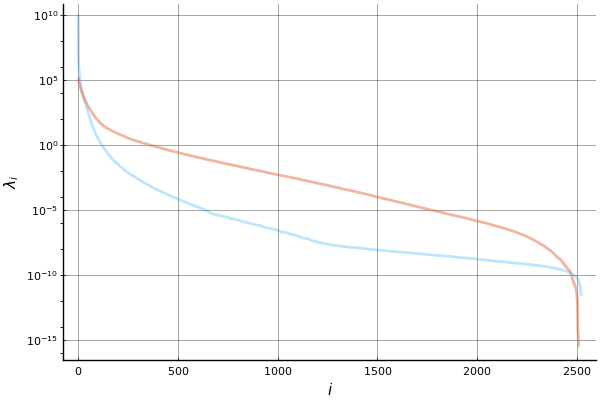

In [43]:
plot(xlabel = L"$i$", ylabel = L"$\lambda_i$", yscale = :log10, 
     grid = true, gridalpha = 0.5, legend = :none)
plot!(abs.(Λ ), linewidth = 2, alpha = 0.25, label = L"$X_v$")
plot!(abs.(Λₑ), linewidth = 2, alpha = 0.5,  label = L"$E$")

# Projection Matrices

In [44]:
function get_Ψ(S, Λ, Ω, tol, k=0)
    E = sum(Λ)
    Eᵣ = 0
    if k == 0
        k = 1
        while 1 - (Eᵣ + Λ[k])/E > tol
            Eᵣ += Λ[k]
            k+=1
        end
    end
    Ψ = S*Ω[:,1:k]
    for i in 1:k
        Ψ[:,i] ./= sqrt(abs.(Λ[i]))
    end
return k, Ψ
end

k, Ψ = get_Ψ(XV, Λ, Ω, 1e-9, 0)
k

131

In [45]:
kₑ, Ψₑ = get_Ψ(E, Λₑ, Ωₑ, 1e-5, 0)
kₑ

637

In [46]:
# # clear 
XV, E = 0, 0
Λ, Λₑ, Ω, Ωₑ = 0, 0, 0, 0
GC.gc()

# DEIM

In [47]:
function deim_get_Π(Ψ)
    N, k = size(Ψ)
    j = argmax(Ψ[:,1])
    Π = zeros(N, k)
    Π[j,1] = 1.0
    r = zeros(N)

    for i in 2:k
        c  = @views (Π[:,1:(i-1)]' * Ψ[:,1:(i-1)]) \ (Π[:,1:(i-1)]' * Ψ[:,i])
        r .= @views Ψ[:,i] .- Ψ[:,1:(i-1)] * c
        j = argmax(r)

        Π[j,i] = 1.0
    end
    return Π
end

deim_get_Π (generic function with 1 method)

In [48]:
@time Πₑ = deim_get_Π(Ψₑ);

 20.489619 seconds (366.68 k allocations: 1.353 GiB, 0.94% gc time, 0.58% compilation time)


In [49]:
h5open("../runs/BoT_Np5e4_k_010_050_np_10_T25_projections.h5", "w") do file
    g = create_group(file, "parameters") # create a group
    g["N_p"] = IP.Nₚ
    g["n_h"] = S.nₕ
    g["p"] = S.p
    g["dt"] = IP.dt
    g["n_t"] = IP.nₜ
    g["n_s"] = IP.nₛ
    g["n_p"] = IP.nₚ
    g["mu_samp"] = μₛₐₘₚ             
    g["mu_train"] = μₜᵣₐᵢₙ
    
    g["k"] = k
    g["k_e"] = kₑ
         
    f = create_group(file, "projections")
    f["Psi"] = Ψ
    f["Psi_e"] = Ψₑ
    f["Pi_e"] = Πₑ
    
    h = create_group(file, "initial_condition")
    h["x_0"] = P₀.x
    h["v_0"] = P₀.v
    h["w"] = P₀.w
end;